In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Cases")
    plt.grid(True)

In [3]:
import csv

In [4]:
confirmed=[]

In [5]:
with open('nation_level_daily.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        confirmed.append(float(row[2]))

In [6]:
time=np.arange(0,len(confirmed))

In [7]:
series = np.array(confirmed)

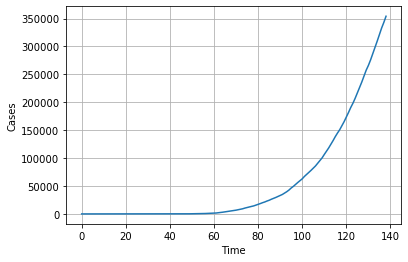

In [8]:
plot_series(time, series)

In [9]:
split_time = 132
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) #makes shape from (3000,) to (3000,1)
    ds = tf.data.Dataset.from_tensor_slices(series) # Slicing a 2D tensor produces 1D tensor elements.
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) #creates tensors of window size+1 with window size tensor as x and +1 tensor as y
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:])) 
    return ds.batch(batch_size).prefetch(1)

In [12]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [14]:
window_size = 64 
batch_size = 128 
shuffle_buffer_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


In [15]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(50, activation="relu", return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

In [16]:
model.compile(loss="mse",
              optimizer="adam")
history = model.fit(train_set, epochs=2000)


Epoch 1/2000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1/1 [==============================] - 0s 9ms/step - loss: 79224406016.0000
Epoch 2/2000
1/1 [==============================] - 0s 940us/step - loss: 68132110336.0000
Epoch 3/2000
1/1 [==============================] - 0s 889us/step - loss: 3529905799168.0000
Epoch 4/2000
1/1 [==============================] - 0s 1ms/step - loss: 59298693120.0000
Epoch 5/2000
1/1 [==============================] - 0s 975us/step - loss: 60127940608.0000
Epoch 6/2000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 983us/step - loss: 93129031680.0000
Epoch 84/2000
1/1 [==============================] - 0s 1ms/step - loss: 82964692992.0000
Epoch 85/2000
1/1 [==============================] - 0s 1ms/step - loss: 103755309056.0000
Epoch 86/2000
1/1 [==============================] - 0s 1ms/step - loss: 107722260480.0000
Epoch 87/2000
1/1 [==============================] - 0s 1ms/step - loss: 114330312704.0000
Epoch 88/2000
1/1 [==============================] - 0s 1ms/step - loss: 83057672192.0000
Epoch 89/2000
1/1 [==============================] - 0s 1ms/step - loss: 77959299072.0000
Epoch 90/2000
1/1 [==============================] - 0s 1ms/step - loss: 77325189120.0000
Epoch 91/2000
1/1 [==============================] - 0s 1ms/step - loss: 72765095936.0000
Epoch 92/2000
1/1 [==============================] - 0s 1ms/step - loss: 58930663424.0000
Epoch 93/2000
1/1 [==============================] - 0s 1ms/step - loss: 83173113856.0000
Epoch 94/2000
1/1 [

1/1 [==============================] - 0s 2ms/step - loss: 26722758656.0000
Epoch 174/2000
1/1 [==============================] - 0s 992us/step - loss: 31800518656.0000
Epoch 175/2000
1/1 [==============================] - 0s 1ms/step - loss: 31438829568.0000
Epoch 176/2000
1/1 [==============================] - 0s 1ms/step - loss: 31622842368.0000
Epoch 177/2000
1/1 [==============================] - 0s 1ms/step - loss: 34218631168.0000
Epoch 178/2000
1/1 [==============================] - 0s 1ms/step - loss: 30964353024.0000
Epoch 179/2000
1/1 [==============================] - 0s 1ms/step - loss: 31189835776.0000
Epoch 180/2000
1/1 [==============================] - 0s 1ms/step - loss: 30946174976.0000
Epoch 181/2000
1/1 [==============================] - 0s 1ms/step - loss: 30695159808.0000
Epoch 182/2000
1/1 [==============================] - 0s 1ms/step - loss: 30139813888.0000
Epoch 183/2000
1/1 [==============================] - 0s 1ms/step - loss: 29893597184.0000
Epoch 184/20

1/1 [==============================] - 0s 1ms/step - loss: 13321080832.0000
Epoch 263/2000
1/1 [==============================] - 0s 1ms/step - loss: 13306281984.0000
Epoch 264/2000
1/1 [==============================] - 0s 1ms/step - loss: 13187365888.0000
Epoch 265/2000
1/1 [==============================] - 0s 2ms/step - loss: 13107787776.0000
Epoch 266/2000
1/1 [==============================] - 0s 1ms/step - loss: 13031585792.0000
Epoch 267/2000
1/1 [==============================] - 0s 1ms/step - loss: 12959083520.0000
Epoch 268/2000
1/1 [==============================] - 0s 1ms/step - loss: 12889236480.0000
Epoch 269/2000
1/1 [==============================] - 0s 1ms/step - loss: 12824036352.0000
Epoch 270/2000
1/1 [==============================] - 0s 1ms/step - loss: 12752091136.0000
Epoch 271/2000
1/1 [==============================] - 0s 1ms/step - loss: 12676357120.0000
Epoch 272/2000
1/1 [==============================] - 0s 944us/step - loss: 12563432448.0000
Epoch 273/20

1/1 [==============================] - 0s 972us/step - loss: 8646549504.0000
Epoch 353/2000
1/1 [==============================] - 0s 1ms/step - loss: 8593976320.0000
Epoch 354/2000
1/1 [==============================] - 0s 1ms/step - loss: 8632168448.0000
Epoch 355/2000
1/1 [==============================] - 0s 1ms/step - loss: 8575078400.0000
Epoch 356/2000
1/1 [==============================] - 0s 1ms/step - loss: 8534989312.0000
Epoch 357/2000
1/1 [==============================] - 0s 1ms/step - loss: 8494947840.0000
Epoch 358/2000
1/1 [==============================] - 0s 1ms/step - loss: 8471309824.0000
Epoch 359/2000
1/1 [==============================] - 0s 1ms/step - loss: 8428557824.0000
Epoch 360/2000
1/1 [==============================] - 0s 1ms/step - loss: 8277850112.0000
Epoch 361/2000
1/1 [==============================] - 0s 1ms/step - loss: 8217013760.0000
Epoch 362/2000
1/1 [==============================] - 0s 1ms/step - loss: 8173121536.0000
Epoch 363/2000
1/1 [===

Epoch 443/2000
1/1 [==============================] - 0s 1ms/step - loss: 5365677056.0000
Epoch 444/2000
1/1 [==============================] - 0s 968us/step - loss: 5307176448.0000
Epoch 445/2000
1/1 [==============================] - 0s 950us/step - loss: 5077231104.0000
Epoch 446/2000
1/1 [==============================] - 0s 1ms/step - loss: 5047770624.0000
Epoch 447/2000
1/1 [==============================] - 0s 1ms/step - loss: 5019507200.0000
Epoch 448/2000
1/1 [==============================] - 0s 1ms/step - loss: 4991933952.0000
Epoch 449/2000
1/1 [==============================] - 0s 987us/step - loss: 4961106432.0000
Epoch 450/2000
1/1 [==============================] - 0s 1ms/step - loss: 4920639488.0000
Epoch 451/2000
1/1 [==============================] - 0s 960us/step - loss: 4891067392.0000
Epoch 452/2000
1/1 [==============================] - 0s 1ms/step - loss: 4791164416.0000
Epoch 453/2000
1/1 [==============================] - 0s 1ms/step - loss: 4736840704.0000
Ep

1/1 [==============================] - 0s 940us/step - loss: 3138427904.0000
Epoch 534/2000
1/1 [==============================] - 0s 2ms/step - loss: 3151542528.0000
Epoch 535/2000
1/1 [==============================] - 0s 1ms/step - loss: 3110506240.0000
Epoch 536/2000
1/1 [==============================] - 0s 1ms/step - loss: 3269795328.0000
Epoch 537/2000
1/1 [==============================] - 0s 998us/step - loss: 3537870848.0000
Epoch 538/2000
1/1 [==============================] - 0s 1ms/step - loss: 3624738304.0000
Epoch 539/2000
1/1 [==============================] - 0s 1ms/step - loss: 3658297600.0000
Epoch 540/2000
1/1 [==============================] - 0s 1ms/step - loss: 3652033536.0000
Epoch 541/2000
1/1 [==============================] - 0s 1ms/step - loss: 3643788800.0000
Epoch 542/2000
1/1 [==============================] - 0s 1ms/step - loss: 3704092416.0000
Epoch 543/2000
1/1 [==============================] - 0s 1ms/step - loss: 3712331008.0000
Epoch 544/2000
1/1 [=

Epoch 624/2000
1/1 [==============================] - 0s 1ms/step - loss: 3126454272.0000
Epoch 625/2000
1/1 [==============================] - 0s 1ms/step - loss: 3091647232.0000
Epoch 626/2000
1/1 [==============================] - 0s 2ms/step - loss: 3085120512.0000
Epoch 627/2000
1/1 [==============================] - 0s 1ms/step - loss: 3078507264.0000
Epoch 628/2000
1/1 [==============================] - 0s 1ms/step - loss: 3072587776.0000
Epoch 629/2000
1/1 [==============================] - 0s 1ms/step - loss: 3066951680.0000
Epoch 630/2000
1/1 [==============================] - 0s 2ms/step - loss: 3061177344.0000
Epoch 631/2000
1/1 [==============================] - 0s 1ms/step - loss: 3055437824.0000
Epoch 632/2000
1/1 [==============================] - 0s 1ms/step - loss: 3049697536.0000
Epoch 633/2000
1/1 [==============================] - 0s 1ms/step - loss: 3043929856.0000
Epoch 634/2000
1/1 [==============================] - 0s 1ms/step - loss: 3038108672.0000
Epoch 635/

1/1 [==============================] - 0s 2ms/step - loss: 2723099648.0000
Epoch 715/2000
1/1 [==============================] - 0s 1ms/step - loss: 2720026624.0000
Epoch 716/2000
1/1 [==============================] - 0s 966us/step - loss: 2716965888.0000
Epoch 717/2000
1/1 [==============================] - 0s 1ms/step - loss: 2713916928.0000
Epoch 718/2000
1/1 [==============================] - 0s 2ms/step - loss: 2710882048.0000
Epoch 719/2000
1/1 [==============================] - 0s 1ms/step - loss: 2707861504.0000
Epoch 720/2000
1/1 [==============================] - 0s 938us/step - loss: 2704854272.0000
Epoch 721/2000
1/1 [==============================] - 0s 1ms/step - loss: 2701861888.0000
Epoch 722/2000
1/1 [==============================] - 0s 1ms/step - loss: 2698882816.0000
Epoch 723/2000
1/1 [==============================] - 0s 1ms/step - loss: 2695918336.0000
Epoch 724/2000
1/1 [==============================] - 0s 1ms/step - loss: 2692968704.0000
Epoch 725/2000
1/1 [=

1/1 [==============================] - 0s 1ms/step - loss: 2492464640.0000
Epoch 805/2000
1/1 [==============================] - 0s 951us/step - loss: 2490268928.0000
Epoch 806/2000
1/1 [==============================] - 0s 1ms/step - loss: 2488080896.0000
Epoch 807/2000
1/1 [==============================] - 0s 1ms/step - loss: 2485897984.0000
Epoch 808/2000
1/1 [==============================] - 0s 1ms/step - loss: 2483719936.0000
Epoch 809/2000
1/1 [==============================] - 0s 1ms/step - loss: 2481545984.0000
Epoch 810/2000
1/1 [==============================] - 0s 1ms/step - loss: 2479379712.0000
Epoch 811/2000
1/1 [==============================] - 0s 1ms/step - loss: 2477217024.0000
Epoch 812/2000
1/1 [==============================] - 0s 1ms/step - loss: 2475060480.0000
Epoch 813/2000
1/1 [==============================] - 0s 1ms/step - loss: 2472905984.0000
Epoch 814/2000
1/1 [==============================] - 0s 1ms/step - loss: 2470761984.0000
Epoch 815/2000
1/1 [===

Epoch 895/2000
1/1 [==============================] - 0s 1ms/step - loss: 2309417728.0000
Epoch 896/2000
1/1 [==============================] - 0s 1ms/step - loss: 2307548416.0000
Epoch 897/2000
1/1 [==============================] - 0s 1ms/step - loss: 2305680384.0000
Epoch 898/2000
1/1 [==============================] - 0s 1ms/step - loss: 2303815424.0000
Epoch 899/2000
1/1 [==============================] - 0s 1ms/step - loss: 2301954304.0000
Epoch 900/2000
1/1 [==============================] - 0s 1ms/step - loss: 2300093440.0000
Epoch 901/2000
1/1 [==============================] - 0s 1ms/step - loss: 2298235136.0000
Epoch 902/2000
1/1 [==============================] - 0s 979us/step - loss: 2296379392.0000
Epoch 903/2000
1/1 [==============================] - 0s 1ms/step - loss: 2294526208.0000
Epoch 904/2000
1/1 [==============================] - 0s 2ms/step - loss: 2292674048.0000
Epoch 905/2000
1/1 [==============================] - 0s 1ms/step - loss: 2290825216.0000
Epoch 90

1/1 [==============================] - 0s 1ms/step - loss: 2148395776.0000
Epoch 986/2000
1/1 [==============================] - 0s 1ms/step - loss: 2146678912.0000
Epoch 987/2000
1/1 [==============================] - 0s 1ms/step - loss: 2144954752.0000
Epoch 988/2000
1/1 [==============================] - 0s 1ms/step - loss: 2143232512.0000
Epoch 989/2000
1/1 [==============================] - 0s 1ms/step - loss: 2141514112.0000
Epoch 990/2000
1/1 [==============================] - 0s 1ms/step - loss: 2139803648.0000
Epoch 991/2000
1/1 [==============================] - 0s 1ms/step - loss: 2138104064.0000
Epoch 992/2000
1/1 [==============================] - 0s 944us/step - loss: 2136411392.0000
Epoch 993/2000
1/1 [==============================] - 0s 1ms/step - loss: 2134724608.0000
Epoch 994/2000
1/1 [==============================] - 0s 935us/step - loss: 2133037824.0000
Epoch 995/2000
1/1 [==============================] - 0s 1ms/step - loss: 2131352832.0000
Epoch 996/2000
1/1 [=

1/1 [==============================] - 0s 1ms/step - loss: 2000714240.0000
Epoch 1076/2000
1/1 [==============================] - 0s 1ms/step - loss: 1999135488.0000
Epoch 1077/2000
1/1 [==============================] - 0s 1ms/step - loss: 1997557888.0000
Epoch 1078/2000
1/1 [==============================] - 0s 1ms/step - loss: 1995981824.0000
Epoch 1079/2000
1/1 [==============================] - 0s 1ms/step - loss: 1994405376.0000
Epoch 1080/2000
1/1 [==============================] - 0s 1ms/step - loss: 1992832896.0000
Epoch 1081/2000
1/1 [==============================] - 0s 1ms/step - loss: 1991260544.0000
Epoch 1082/2000
1/1 [==============================] - 0s 990us/step - loss: 1989689728.0000
Epoch 1083/2000
1/1 [==============================] - 0s 1ms/step - loss: 1988117888.0000
Epoch 1084/2000
1/1 [==============================] - 0s 1ms/step - loss: 1986549632.0000
Epoch 1085/2000
1/1 [==============================] - 0s 952us/step - loss: 1984981760.0000
Epoch 1086/

Epoch 1165/2000
1/1 [==============================] - 0s 1ms/step - loss: 1863664640.0000
Epoch 1166/2000
1/1 [==============================] - 0s 1ms/step - loss: 1862198016.0000
Epoch 1167/2000
1/1 [==============================] - 0s 1ms/step - loss: 1860733696.0000
Epoch 1168/2000
1/1 [==============================] - 0s 1ms/step - loss: 1859270272.0000
Epoch 1169/2000
1/1 [==============================] - 0s 967us/step - loss: 1857807744.0000
Epoch 1170/2000
1/1 [==============================] - 0s 949us/step - loss: 1856347648.0000
Epoch 1171/2000
1/1 [==============================] - 0s 1ms/step - loss: 1854886144.0000
Epoch 1172/2000
1/1 [==============================] - 0s 1ms/step - loss: 1853428480.0000
Epoch 1173/2000
1/1 [==============================] - 0s 1ms/step - loss: 1851970816.0000
Epoch 1174/2000
1/1 [==============================] - 0s 1ms/step - loss: 1850514048.0000
Epoch 1175/2000
1/1 [==============================] - 0s 1ms/step - loss: 1849059456.

1/1 [==============================] - 0s 1ms/step - loss: 1737698304.0000
Epoch 1255/2000
1/1 [==============================] - 0s 1ms/step - loss: 1736333056.0000
Epoch 1256/2000
1/1 [==============================] - 0s 1ms/step - loss: 1734968576.0000
Epoch 1257/2000
1/1 [==============================] - 0s 950us/step - loss: 1733603840.0000
Epoch 1258/2000
1/1 [==============================] - 0s 1ms/step - loss: 1732242304.0000
Epoch 1259/2000
1/1 [==============================] - 0s 1ms/step - loss: 1730880896.0000
Epoch 1260/2000
1/1 [==============================] - 0s 1ms/step - loss: 1729520768.0000
Epoch 1261/2000
1/1 [==============================] - 0s 1ms/step - loss: 1728162304.0000
Epoch 1262/2000
1/1 [==============================] - 0s 1ms/step - loss: 1726802816.0000
Epoch 1263/2000
1/1 [==============================] - 0s 1ms/step - loss: 1725446272.0000
Epoch 1264/2000
1/1 [==============================] - 0s 968us/step - loss: 1724090624.0000
Epoch 1265/

1/1 [==============================] - 0s 1ms/step - loss: 1620235008.0000
Epoch 1344/2000
1/1 [==============================] - 0s 1ms/step - loss: 1618959360.0000
Epoch 1345/2000
1/1 [==============================] - 0s 1ms/step - loss: 1617684608.0000
Epoch 1346/2000
1/1 [==============================] - 0s 1ms/step - loss: 1616410624.0000
Epoch 1347/2000
1/1 [==============================] - 0s 2ms/step - loss: 1615136384.0000
Epoch 1348/2000
1/1 [==============================] - 0s 1ms/step - loss: 1613862272.0000
Epoch 1349/2000
1/1 [==============================] - 0s 1ms/step - loss: 1612587776.0000
Epoch 1350/2000
1/1 [==============================] - 0s 1ms/step - loss: 1611310592.0000
Epoch 1351/2000
1/1 [==============================] - 0s 1ms/step - loss: 1610028160.0000
Epoch 1352/2000
1/1 [==============================] - 0s 1ms/step - loss: 1608738688.0000
Epoch 1353/2000
1/1 [==============================] - 0s 1ms/step - loss: 1607451648.0000
Epoch 1354/2000

1/1 [==============================] - 0s 978us/step - loss: 1509202560.0000
Epoch 1434/2000
1/1 [==============================] - 0s 1ms/step - loss: 1508010880.0000
Epoch 1435/2000
1/1 [==============================] - 0s 1ms/step - loss: 1506820480.0000
Epoch 1436/2000
1/1 [==============================] - 0s 1ms/step - loss: 1505630208.0000
Epoch 1437/2000
1/1 [==============================] - 0s 1ms/step - loss: 1504441472.0000
Epoch 1438/2000
1/1 [==============================] - 0s 1ms/step - loss: 1503254144.0000
Epoch 1439/2000
1/1 [==============================] - 0s 1ms/step - loss: 1502066432.0000
Epoch 1440/2000
1/1 [==============================] - 0s 955us/step - loss: 1500879872.0000
Epoch 1441/2000
1/1 [==============================] - 0s 1ms/step - loss: 1499694208.0000
Epoch 1442/2000
1/1 [==============================] - 0s 2ms/step - loss: 1498509184.0000
Epoch 1443/2000
1/1 [==============================] - 0s 1ms/step - loss: 1497326336.0000
Epoch 1444/

Epoch 1523/2000
1/1 [==============================] - 0s 1ms/step - loss: 1405312768.0000
Epoch 1524/2000
1/1 [==============================] - 0s 1ms/step - loss: 1404195328.0000
Epoch 1525/2000
1/1 [==============================] - 0s 1ms/step - loss: 1403078528.0000
Epoch 1526/2000
1/1 [==============================] - 0s 1ms/step - loss: 1401962112.0000
Epoch 1527/2000
1/1 [==============================] - 0s 977us/step - loss: 1400846464.0000
Epoch 1528/2000
1/1 [==============================] - 0s 1ms/step - loss: 1399732480.0000
Epoch 1529/2000
1/1 [==============================] - 0s 1ms/step - loss: 1398617856.0000
Epoch 1530/2000
1/1 [==============================] - 0s 1ms/step - loss: 1397504256.0000
Epoch 1531/2000
1/1 [==============================] - 0s 1ms/step - loss: 1396392704.0000
Epoch 1532/2000
1/1 [==============================] - 0s 1ms/step - loss: 1395280640.0000
Epoch 1533/2000
1/1 [==============================] - 0s 969us/step - loss: 1394169984.

1/1 [==============================] - 0s 1ms/step - loss: 1308510208.0000
Epoch 1613/2000
1/1 [==============================] - 0s 1ms/step - loss: 1307442176.0000
Epoch 1614/2000
1/1 [==============================] - 0s 1ms/step - loss: 1306374400.0000
Epoch 1615/2000
1/1 [==============================] - 0s 1ms/step - loss: 1305305600.0000
Epoch 1616/2000
1/1 [==============================] - 0s 1ms/step - loss: 1304236672.0000
Epoch 1617/2000
1/1 [==============================] - 0s 1ms/step - loss: 1303166208.0000
Epoch 1618/2000
1/1 [==============================] - 0s 1ms/step - loss: 1302097664.0000
Epoch 1619/2000
1/1 [==============================] - 0s 1ms/step - loss: 1301026176.0000
Epoch 1620/2000
1/1 [==============================] - 0s 1ms/step - loss: 1299954944.0000
Epoch 1621/2000
1/1 [==============================] - 0s 1ms/step - loss: 1298882304.0000
Epoch 1622/2000
1/1 [==============================] - 0s 1ms/step - loss: 1297809408.0000
Epoch 1623/2000

1/1 [==============================] - 0s 1ms/step - loss: 1215514752.0000
Epoch 1702/2000
1/1 [==============================] - 0s 2ms/step - loss: 1214512000.0000
Epoch 1703/2000
1/1 [==============================] - 0s 1ms/step - loss: 1213507456.0000
Epoch 1704/2000
1/1 [==============================] - 0s 1ms/step - loss: 1212500096.0000
Epoch 1705/2000
1/1 [==============================] - 0s 1ms/step - loss: 1211492736.0000
Epoch 1706/2000
1/1 [==============================] - 0s 1ms/step - loss: 1210486272.0000
Epoch 1707/2000
1/1 [==============================] - 0s 2ms/step - loss: 1209480960.0000
Epoch 1708/2000
1/1 [==============================] - 0s 1ms/step - loss: 1208475904.0000
Epoch 1709/2000
1/1 [==============================] - 0s 1ms/step - loss: 1207471104.0000
Epoch 1710/2000
1/1 [==============================] - 0s 1ms/step - loss: 1206489344.0000
Epoch 1711/2000
1/1 [==============================] - 0s 1ms/step - loss: 1205550592.0000
Epoch 1712/2000

Epoch 1791/2000
1/1 [==============================] - 0s 1ms/step - loss: 1128780800.0000
Epoch 1792/2000
1/1 [==============================] - 0s 1ms/step - loss: 1127849984.0000
Epoch 1793/2000
1/1 [==============================] - 0s 1ms/step - loss: 1126920064.0000
Epoch 1794/2000
1/1 [==============================] - 0s 1ms/step - loss: 1125991424.0000
Epoch 1795/2000
1/1 [==============================] - 0s 1ms/step - loss: 1125063296.0000
Epoch 1796/2000
1/1 [==============================] - 0s 1ms/step - loss: 1124133888.0000
Epoch 1797/2000
1/1 [==============================] - 0s 1ms/step - loss: 1123206400.0000
Epoch 1798/2000
1/1 [==============================] - 0s 1ms/step - loss: 1122279808.0000
Epoch 1799/2000
1/1 [==============================] - 0s 1ms/step - loss: 1121354368.0000
Epoch 1800/2000
1/1 [==============================] - 0s 957us/step - loss: 1120431104.0000
Epoch 1801/2000
1/1 [==============================] - 0s 1ms/step - loss: 1119505664.00

1/1 [==============================] - 0s 1ms/step - loss: 1048564416.0000
Epoch 1881/2000
1/1 [==============================] - 0s 1ms/step - loss: 1047691008.0000
Epoch 1882/2000
1/1 [==============================] - 0s 1ms/step - loss: 1046819072.0000
Epoch 1883/2000
1/1 [==============================] - 0s 1ms/step - loss: 1045948416.0000
Epoch 1884/2000
1/1 [==============================] - 0s 1ms/step - loss: 1045078016.0000
Epoch 1885/2000
1/1 [==============================] - 0s 970us/step - loss: 1044207616.0000
Epoch 1886/2000
1/1 [==============================] - 0s 1ms/step - loss: 1043339392.0000
Epoch 1887/2000
1/1 [==============================] - 0s 1ms/step - loss: 1042471488.0000
Epoch 1888/2000
1/1 [==============================] - 0s 1ms/step - loss: 1041603136.0000
Epoch 1889/2000
1/1 [==============================] - 0s 1ms/step - loss: 1040736000.0000
Epoch 1890/2000
1/1 [==============================] - 0s 1ms/step - loss: 1039870080.0000
Epoch 1891/20

1/1 [==============================] - 0s 2ms/step - loss: 972538176.0000
Epoch 1971/2000
1/1 [==============================] - 0s 1ms/step - loss: 971720512.0000
Epoch 1972/2000
1/1 [==============================] - 0s 1ms/step - loss: 970903424.0000
Epoch 1973/2000
1/1 [==============================] - 0s 1ms/step - loss: 970088128.0000
Epoch 1974/2000
1/1 [==============================] - 0s 1ms/step - loss: 969272576.0000
Epoch 1975/2000
1/1 [==============================] - 0s 1ms/step - loss: 968457536.0000
Epoch 1976/2000
1/1 [==============================] - 0s 1ms/step - loss: 967644480.0000
Epoch 1977/2000
1/1 [==============================] - 0s 1ms/step - loss: 966829632.0000
Epoch 1978/2000
1/1 [==============================] - 0s 1ms/step - loss: 966016448.0000
Epoch 1979/2000
1/1 [==============================] - 0s 1ms/step - loss: 965205312.0000
Epoch 1980/2000
1/1 [==============================] - 0s 1ms/step - loss: 964392896.0000
Epoch 1981/2000
1/1 [=====

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

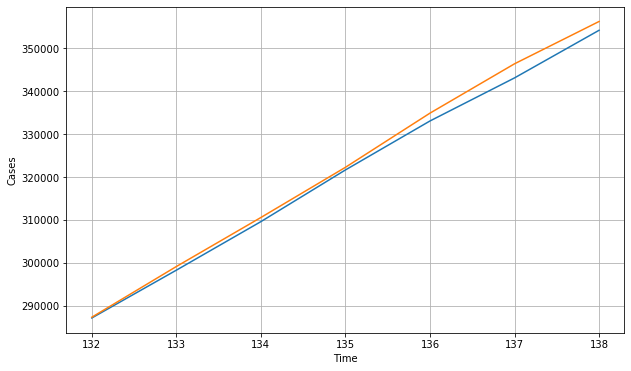

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [20]:
tf.keras.metrics.mean_absolute_percentage_error(x_valid, rnn_forecast).numpy()

0.41880706